# Cardinal Users Guide

This Users Guide provides documentation on Cardinal algorithms and functions. For more practical guidance on getting started with applying Cardinal to data, see the Quick Start guide.

In [1]:
from obspy import read, Stream
import sys, dask, time
import matplotlib.pyplot as plt
import numpy as np
sys.path.append('/Users/sarrowsmith/Box/Work/github/cardinal/')
import cardinal

## What is Cardinal?

Cardinal is an array processing package with a design goal to support processing data in multiple time/frequency blocks with a variety of different array methods.

The figure below provides a high-level schematic of the Cardinal workflow. The workflow can be described in terms of a segmentor, an array processor, and an aggregator. *At the present time, only the first two of these components are developed in preliminary form, and only one array processing method is implemented.*

![title](cardinal.png)

## Segmentor

The segmentor provides the specification of processing time-frequency blocks. In practice, these blocks are defined using a Pandas dataframe called ```f_bands``` (see the example below).

The user can define their own ```f_bands``` using the following parameters for each frequency band:

```band```: An integer that denotes a unique band ID

```fmin```: The minimum frequency of the processing band in Hertz

```fmax```: The maximum frequency of the processing band in Hertz

```fcenter```: The center frequency: (fmax+fmin)/2

```win```: The time window in seconds

```step```: The amount the time window advances in seconds

While the user can create their own f_bands, Cardinal also provides some utility functions that generate frequency bands. These include the following (query the functions in Python for more details on inputs):

```python
pmcc_fbands()
```
- This function returns the PMCC configuration described in Matoza et al. (2013): https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2012GL054329

```python
extend_pmcc_fbands(f_bands, fmax)
```

- This function extends the PMCC configuration described above, which only goes up to 5 Hz, to a higher maximum frequency, fmax. The function uses the same logarithmic frequency band spacing and window length spacing rules that the PMCC f-bands described in Matoza et al. (2013) use, where window length is linearly proportional to period

```python
make_custom_fbands(...)
```

- This function currently supports three types of frequency band, 'third_octave', 'octave', and 'decade'.

In [2]:
f_bands = cardinal.pmcc_fbands()
f_bands

,band,fmin,fcenter,fmax,win,step
0,1,0.0100,0.0126,0.0151,200.0000,20.0000
1,2,0.0151,0.0190,0.0229,142.1606,14.2161
2,3,0.0229,0.0288,0.0347,103.9404,10.3940
3,4,0.0347,0.0436,0.0524,78.6846,7.8685
4,5,0.0524,0.0659,0.0794,61.9956,6.1996
5,6,0.0794,0.0997,0.1201,50.9676,5.0968
6,7,0.1201,0.1509,0.1818,43.6803,4.3680
7,8,0.1818,0.2284,0.2751,38.8648,3.8865
8,9,0.2751,0.3457,0.4163,35.6828,3.5683
9,10,0.4163,0.5231,0.6300,33.5801,3.3580


#### The PMCC configuration

The PMCC frequency bands are logarithmic, with time window based on the largest period of each frequency band, as shown in the plot below.

Populating the interactive namespace from numpy and matplotlib


<IPython.core.display.Javascript object>


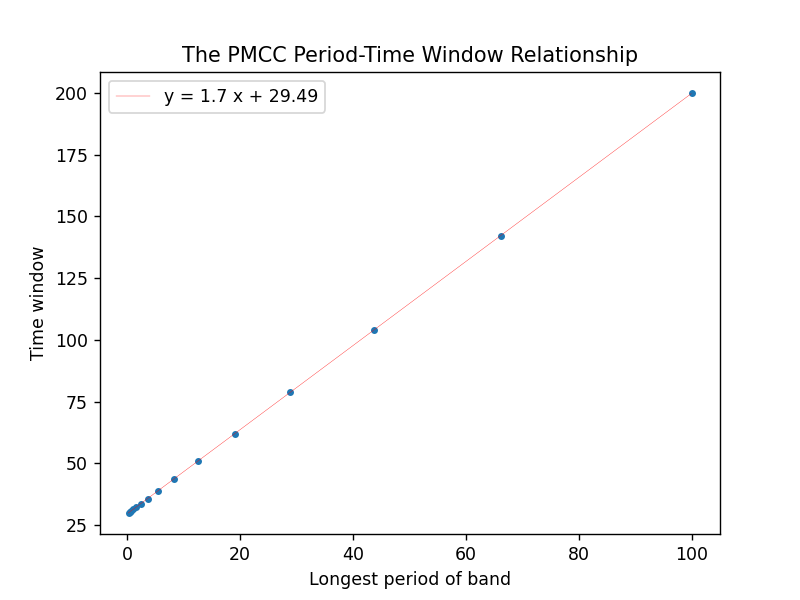

In [3]:
%pylab notebook
fig, ax = plt.subplots()

ax.plot(1/f_bands['fmin'].values, f_bands['win'].values, '.')
m, b = np.polyfit(1/f_bands['fmin'].values, f_bands['win'].values, 1)

periods = np.arange(0.2,100,0.1)
times = m*periods + b
ax.plot(periods, times, 'r-', label='y = ' + str(round(m,2)) + ' x + ' + \
        str(round(b,2)), linewidth=0.2)
plt.xlabel('Longest period of band')
plt.ylabel('Time window')
plt.title('The PMCC Period-Time Window Relationship')
ax.legend()
plt.show()

#### The make_custom_fbands configurations

The ```make_custom_fbands``` function is another utility that gives a few more options for constructing the time-frequency bands. The user defines a minimum frequency, ```f_min```, a maximum frequency, ```f_max```, a minimum time window, ```win_min```, a maximum time window, ```win_max```, a time overlap, ```overlap```, and a type of f-band specification (where the options are ```third_octave```, ```octave```, and ```decade```.

The relationship between time window and frequency band is assumed linear with period and fit by constructing a straight line between the points defined by ```(1/f_min, win_max), (1/f_max, win_min)```. This is illustrated in the example below.

In [4]:
f_bands = cardinal.make_custom_fbands(f_min=0.01, f_max=50, win_min=3, win_max=200, 
                                      overlap=0.1, type='third_octave')

In [5]:
f_bands

,band,fmin,fcenter,fmax,win,step
0,1.0,0.010000,0.011300,0.012599,177.337841,17.733784
1,2.0,0.012599,0.014237,0.015874,141.363906,14.136391
2,3.0,0.015874,0.017937,0.020000,112.811375,11.281138
3,4.0,0.020000,0.022599,0.025198,90.149217,9.014922
4,5.0,0.025198,0.028473,0.031748,72.162249,7.216225
5,6.0,0.031748,0.035874,0.040000,57.885984,5.788598
6,7.0,0.040000,0.045198,0.050397,46.554904,4.655490
7,8.0,0.050397,0.056946,0.063496,37.561421,3.756142
8,9.0,0.063496,0.071748,0.080000,30.423288,3.042329
9,10.0,0.080000,0.090397,0.100794,24.757748,2.475775


Populating the interactive namespace from numpy and matplotlib


<IPython.core.display.Javascript object>


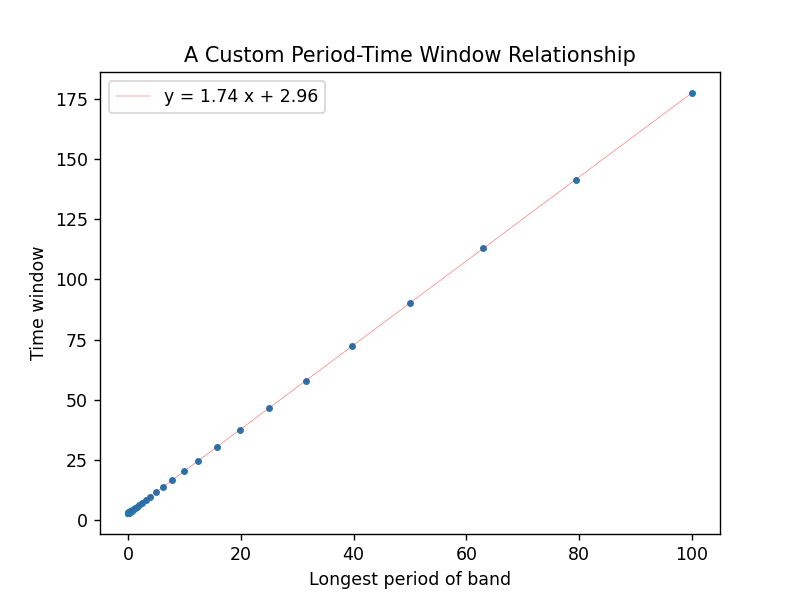

In [6]:
%pylab notebook
fig, ax = plt.subplots()

ax.plot(1/f_bands['fmin'].values, f_bands['win'].values, '.')
m, b = np.polyfit(1/f_bands['fmin'].values, f_bands['win'].values, 1)

periods = np.arange(0.2,100,0.1)
times = m*periods + b
ax.plot(periods, times, 'r-', label='y = ' + str(round(m,2)) + ' x + ' + \
        str(round(b,2)), linewidth=0.2)
plt.xlabel('Longest period of band')
plt.ylabel('Time window')
plt.title('A Custom Period-Time Window Relationship')
ax.legend()
plt.show()

The frequency bands are non-overlapping bands that start at the minimum frequency and extend up to the maximum frequency in either third octave, octave, or decade bands.

For third octave bands, each band is constructed as:

\begin{equation}
f_{\text{max}} = 2^{\frac{1}{3}} f_{\text{min}}
\end{equation}

For octave bands:

\begin{equation}
f_{\text{max}} = 2 f_{\text{min}}
\end{equation}

For decade bands:

\begin{equation}
f_{\text{max}} = 10 f_{\text{min}}
\end{equation}

### Designing your own f_bands

There is no model for deriving optimal time windows and frequency bands, and these are often tuned by hand based on a given array configuration and the signals of interest. The time window should be based on the array spacing and the dominant signal period. Some general guidelines for creating your own ```f_bands``` are:

- Choose a time window that is sufficiently long for the largest sensor separation in your array ($\delta$) *** . A general guideline would be to make the time window at least 1.5 $\times \frac{\delta}{v_0}$, where $v_0$ is the medium velocity at the array.
- Choose a time window that is sufficiently long for the largest period in your filter band ($T_{max}$). In PMCC, the minimum time window is 2 $\times T_{max}$.
- Choose a time window that is short enough that it provides sufficient temporal resolution and does not include multiple phases in the same window.

The use of multiple time-frequency blocks in Cardinal enables a more general processing scheme for application to signals with different temporal and spectral characteristics. However, if defining their own ```f_band``` parameters, the user should ensure that the time window parameters are suitable for each frequency band.

*** For processing signals from arrays that are larger than optimal for the signal wavelength, Cardinal can time-shift the signals for a given slowness direction before array processing. This option is suitable when the approximate DOA is known. Refer to the details about slowness correction below.

## Array Processor

The array processor applies an array processing routine to each time-frequency block of data separately. It requires the following inputs:

- ObsPy Stream object containing the waveform data for the array, and element coordinates
- Name of the reference element
- ```f_bands``` (the output of the Segmentor)
- Slowness plane parameters
- Slowness correction parameters

The slowness correction option tells Cardinal to time-shift the signals for a given slowness direction before applying array processing. This enables the user to choose a shorter time window than required by the physical separation of the sensors for processing signals from a particular direction.

### Algorithms

There are several array processing algorithms that can be applied to waveform data. The design goal for Cardinal is to make it straightforward to substitute different array methods in a modular way.

#### Standard ObsPy FK algorithm

This algorithm *currently* applies the routine to the full array and each band in f_bands. The user should verify that the parameters are physically consistent with the array configuration.

For each time-frequency block, the Discrete Fourier transform (DFT) is first applied to each time window using a Cosine taper. The 22% total taper (which tapers 11% from the start, and 11% from the end) is an ObsPy default.

Next, the DFT for only frequencies between ```fmin``` and ```fmax``` is extracted.

The method works by defining a 'slowness grid' over trial values of $\underline{u} = \left(u_x, u_y \right)$ and estimating the power of the beamformed signal for each trial value of slowness. The slowness grid should cover a plane over slowness values that extend out at least to the medium slowness, $u_0$.

For each slowness parameter, the power is expressed below (where $f_1$ and $f_2$ correspond to the fmin and fmax parameters for each frequency band):

\begin{equation}
    P \left(u_x, u_y \right) = \frac{1}{N_T^2} \sum_{f=f_1}^{f_2} \left| \frac{1}{N} \sum_{i=1}^N X_i(f) e^{-i 2 \pi f \underline{r}_i \cdot \underline{u}} \right|^2
\end{equation}

where the normalization factor of $\frac{1}{N_T^2}$ follows from Parseval's theorem (this is not implemented in ObsPy, but only relative power values are used in practice).

The basic call to the standard FK array processing module is as follows:

```python
cardinal.sliding_time_array_fk_multifreq(...)
```

Or, to process a single frequency band:

```python
cardinal.sliding_time_array_fk(...)
```

As an example, the default parameters of ```sliding_time_array_fk_multifreq``` are shown below:

```python
sliding_time_array_fk_multifreq(st, element, f_bands, t_start=None, 
                                t_end=None, n_workers=1, sll_x=-3.6, 
                                slm_x=3.6, sll_y=-3.6, slm_y=3.6, 
                                sl_s=0.18, sl_corr=[0.,0.])
```

Here, the defaults of all the parameters are defined. Setting ```t_start``` and ```t_end``` to ```None``` processes the whole Stream, and setting ```n_workers``` to 1 uses only 1 thread. The slowness grid, $\underline{u}$ is defined by minimum and maximum slownesses in both x (```sll_x, slm_x```) and y (```sll_y, slm_y```) directions, and a slowness spacing that defines the resolution, ```sl_s```. Setting ```sl_corr=[0,0]``` simply states that no slowness correction is applied.

The output of array processing is a vector of times, and matrices that contain the backazimuth, trace (or phase) velocity, and semblance. These matrices have dimension $(N_f, N_t)$ where $N_f$ is the number of frequency bands and $N_t$ is the number of time windows in the highest frequency band. The results from frequency bands with longer time windows are resampled onto the shortest time window spacing.

Cardinal includes a plotting utility for plotting the results:

```python
plot_sliding_window_multifreq(...)
```